In [1]:
import numpy as np
import scipy
import sklearn
from sklearn.decomposition import NMF
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture,BayesianGaussianMixture

import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
mpl.rcParams['image.cmap'] = 'Greys'
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False



import sys,os,pdb,copy,pickle
from importlib import reload
# import pynapple as nap

sys.path.append('/mnt/home/szheng/projects/seq_detection2/code')
sys.path.append('/mnt/home/szheng/projects/util_code')
sys.path.append('/mnt/home/szheng/projects/nmf_analysis')
sys.path.append('/mnt/home/szheng/projects/nmf_analysis/scripts')
sys.path.append('/mnt/home/szheng/projects/cluster_spikes')
sys.path.append('/mnt/home/szheng/projects/place_variability/code')
import data_prep_new as dpn
import place_cell_analysis as pa
import plot_helper as ph
import preprocess as prep
import nmf_analysis as na
import nmf_plot as nmfp
reload(na)

import raster_new as rn
import data_prep_pyn as dpp


import change_point_analysis as cpa
import change_point_plot as cpp

import place_field_analysis as pf

import switch_analysis_one_session as saos
reload(saos)

import process_central_arm as pca 
import change_point_analysis_central_arm_seperate as cpacas

import misc
reload(misc)
from misc import get_nth_key, get_nth_val

67 sessions!
67 sessions!


In [250]:
np.random.seed(123)

In [2]:
import matplotlib
matplotlib.rcParams['svg.fonttype'] = 'none'

In [3]:

figdir = '/mnt/home/szheng/ceph/place_variability/fig/paper/suppfigure_waveform'
misc.get_or_create_subdir(figdir)
suppfigdir =misc.get_or_create_subdir(figdir,'supp')
data_dir = '/mnt/home/szheng/ceph/place_variability/data/paper'
misc.get_or_create_subdir(data_dir)


/mnt/home/szheng/ceph/place_variability/fig/paper/suppfigure_waveform
/mnt/home/szheng/ceph/place_variability/fig/paper/suppfigure_waveform/supp
/mnt/home/szheng/ceph/place_variability/data/paper


'/mnt/home/szheng/ceph/place_variability/data/paper'

In [4]:
import database
db = database.db

subdb = db.query('owner=="roman"').sort_values('n_pyr_putative',ascending=False)
subdb = subdb.query('ntrials>=20&n_neurons>=50')
to_exclude_sess = ['e16_3m2_211211']
subdb=subdb.loc[~subdb['sess_name'].isin(to_exclude_sess)]


import pf_recombine_central as pfrc
import fr_map_one_session as fmos
import switch_detection_one_session as sdos
import get_all_switch_add_metrics as gasam

import preprocess_one_session as prepos

/mnt/home/szheng/ceph/envs/jax/lib/python3.9/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.2, the latest is 0.5.4.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


In [5]:
import neo

In [7]:
fn = 'prepped_data_agg.p'
fn_full = os.path.join(data_dir,fn)
prepped_data_agg = pickle.load(open(fn_full,'rb'))

all_fields_recombined_all = prepped_data_agg['all_fields_recombined_all']
pf_params_recombined_all=  prepped_data_agg['pf_params_recombined_all']
fr_map_trial_df_all= prepped_data_agg['fr_map_trial_df_all']
occu_map_all = prepped_data_agg['occu_map_all']
fr_map_all = prepped_data_agg['fr_map_all']
fr_map_trial_df_pyr_combined_all = prepped_data_agg['fr_map_trial_df_pyr_combined_all']

pval_all = prepped_data_agg['pval_all']
X_pwc_all = prepped_data_agg['X_pwc_all']
X_raw_all = prepped_data_agg['X_raw_all']
changes_df_all = prepped_data_agg['changes_df_all']
var_res_all_test = prepped_data_agg['var_res_all']
# corr_all = prepped_data_agg['corr_all']
all_sw_d_all = prepped_data_agg['all_sw_d_all']
all_sw_with_metrics_d_all = prepped_data_agg['all_sw_with_metrics_d_all']
best_n_all_test = prepped_data_agg['best_n_all']
spk_beh_df_all = prepped_data_agg['spk_beh_df_all']
pf_params_all = prepped_data_agg['pf_params_all']

ntrials_per_tt=fr_map_trial_df_all.groupby(level=(0,1,2,3)).apply(lambda x:x.dropna(axis=1,how='all').shape[1])
ntrials_mask = ntrials_per_tt.groupby(level=(0,1,2)).apply(lambda x:(x>=7).all()) 

trial_index_to_index_within_df_all=prepped_data_agg['trial_index_to_index_within_df_all']

In [ ]:
row = subdb.iloc[0]
data_dir_full = row['data_dir_full']
sess_name=row['sess_name']

In [8]:


mat_to_return=prep.load_stuff(data_dir_full,sessionPulses='*SessionPulses.Events.mat')
# sessionPulses=mat_to_return['sessionPulses']
# filtered = mat_to_return['filtered']
behavior=mat_to_return['behavior']
# ripples = mat_to_return['ripples']
cell_metrics = mat_to_return['cell_metrics']

In [10]:
prep_res = dpp.load_spk_beh_df(data_dir_full,force_reload=False,extra_load={})
# prep_res = dpp.load_spk_beh_df(data_dir_full,force_reload=True,extra_load=dict(sessionPulses='*SessionPulses.Events.mat',filtered='*thetaFiltered.lfp.mat'))
spk_beh_df=prep_res['spk_beh_df']
_,spk_beh_df = dpp.group_into_trialtype(spk_beh_df)
# spk_beh_df,_=dpp.add_lin_binned(spk_beh_df,nbins=100)
spk_beh_df,_=dpp.add_lin_binned(spk_beh_df,bin_size=2.2,nbins=None)
cell_cols_d = prep_res['cell_cols_d']
beh_df = prep_res['beh_df']
beh_df_d,beh_df=dpp.group_into_trialtype(beh_df)
spike_trains = prep_res['spike_trains']


In [11]:
ani,sess,ti = row['animal_name.1'],row['sess_name'],0
all_sw_onesess=all_sw_with_metrics_d_all.loc[ani,sess,ti]

/tmp/ipykernel_1756189/3543618691.py:2: PerformanceWarning: indexing past lexsort depth may impact performance.
  all_sw_onesess=all_sw_with_metrics_d_all.loc[ani,sess,ti]


# after running, load saved results and plot

In [399]:
# res = {'all':waveform_allspk_alluid_ep_allsw,'avg':waveform_avgspk_alluid_ep_allsw}
save_fn_full = os.path.join(data_dir_full,'py_data','waveform_peri_sw.p')
import pickle
res=pickle.load(open(save_fn_full,'rb'))

In [44]:
def get_spk_amplitude(onespk):
    midpoint=(len(onespk)-1)//2
    peaks,_=scipy.signal.find_peaks(onespk)
    trough=peaks[peaks<midpoint][-1]
    amp = onespk[trough] - onespk[midpoint]
    return amp

### get spk amplitude

In [422]:
%%time
spk_amp_prepost_all = {} # avg
for onoff in res['avg'].keys():
    spk_amp_prepost_all[onoff] = {}
    for sw_id in res['avg'][onoff].keys():
        spk_amp_prepost_all[onoff][sw_id] = {}
        for prepost in res['avg'][onoff][sw_id].keys():
            spk_amp_prepost_all[onoff][sw_id][prepost]={}
            for uid in res['avg'][onoff][sw_id][prepost].keys():
                onespk = res['avg'][onoff][sw_id][prepost][uid]
                spk_amp_prepost_all[onoff][sw_id][prepost][uid] = get_spk_amplitude(onespk)
            spk_amp_prepost_all[onoff][sw_id][prepost] = pd.Series(spk_amp_prepost_all[onoff][sw_id][prepost])
        spk_amp_prepost_all[onoff][sw_id] = pd.concat(spk_amp_prepost_all[onoff][sw_id]).unstack(level=0).dropna(axis=0)
    spk_amp_prepost_all[onoff] = pd.concat(spk_amp_prepost_all[onoff])
spk_amp_prepost_all = pd.concat(spk_amp_prepost_all)

CPU times: user 1.13 s, sys: 0 ns, total: 1.13 s
Wall time: 1.13 s


In [423]:
# %%time
# spk_amp_prepost_all_individual = {} # all
# for onoff in res['all'].keys():
#     spk_amp_prepost_all_individual[onoff] = {}
#     for sw_id in res['all'][onoff].keys():
#         spk_amp_prepost_all_individual[onoff][sw_id] = {}
#         for prepost in res['all'][onoff][sw_id].keys():
#             spk_amp_prepost_all_individual[onoff][sw_id][prepost]={}
#             for uid in res['all'][onoff][sw_id][prepost].keys():
#                 allspk_oneuid = res['all'][onoff][sw_id][prepost][uid]
#                 amp_d = {}
#                 amp_l = []
#                 for onespk in allspk_oneuid:
#                     try:
#                         amp = get_spk_amplitude(onespk)
#                         amp_l.append(amp)
#                     except:
#                         pass
#                 amp_d['mean'] = np.mean(amp_l)
#                 amp_d['std'] = np.std(amp_l)
#                 amp_d['se'] = amp_d['std'] / np.sqrt(len(amp_l))
#                 amp_d['n']=len(amp_l)
#                 spk_amp_prepost_all_individual[onoff][sw_id][prepost][uid] = pd.Series(amp_d)
#             spk_amp_prepost_all_individual[onoff][sw_id][prepost] = pd.DataFrame(spk_amp_prepost_all_individual[onoff][sw_id][prepost])
#         spk_amp_prepost_all_individual[onoff][sw_id] = pd.concat(spk_amp_prepost_all_individual[onoff][sw_id]).unstack(level=0).dropna(axis=0)
#     spk_amp_prepost_all_individual[onoff] = pd.concat(spk_amp_prepost_all_individual[onoff])
# spk_amp_prepost_all_individual = pd.concat(spk_amp_prepost_all_individual)

CPU times: user 42.7 s, sys: 163 ms, total: 42.9 s
Wall time: 42.9 s


In [424]:
# %%time
# spk_amp_prepost_all_individual_restack = spk_amp_prepost_all_individual.stack(level=0).swaplevel(-1,-2)


# gpb=spk_amp_prepost_all_individual_restack.groupby(level=(0,1,2))
# cohen_d_all = {}
# for k,val in gpb:
#     val=val.loc[k]
#     mean=val.loc['mean']
#     mean_diff=mean['post']-mean['pre']
#     s =np.sqrt((val.loc['std']**2 *(val.loc['n']-1)).sum() / (val.loc['n'].sum()-2))
#     cohen_d_all[k]=d = mean_diff/s

# cohen_d_all=pd.Series(cohen_d_all)

(0.0, 500.0)

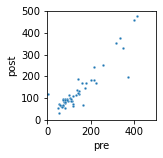

In [99]:
# fig,ax=plt.subplots(figsize=(2,2))
# ax.set_aspect('equal')
# sns.scatterplot(data=spk_amp_prepost_all.loc[1,382],x='pre',y='post',s=6,ax=ax)
# ax.set_xlim([0,500])
# ax.set_ylim([0,500])


In [618]:
# one example ratemap
sub=all_sw_onesess.query('switch==1&pre_mean_fr_all_norm<0.3&uid==150')
row=sub.iloc[2]
sw_id=row.name
tt,uid,field_index,index_within,trial_index=row['trialtype'],row['uid'],row['field_index'],row['index_within'],row['trial_index']

/tmp/ipykernel_1756189/315407457.py:5: PerformanceWarning: indexing past lexsort depth may impact performance.
  frmap_one=fr_map_trial_df_pyr_combined_all.loc[(ani,sess,0,tt_plot,uid),:].dropna(axis=1)
/mnt/home/szheng/projects/util_code/plot_helper.py:626: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(x_tick_labels, rotation=0)


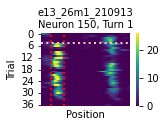

In [619]:
trial_index_to_index_within_df_one=trial_index_to_index_within_df_all[ani,sess].loc[ti]
row=trial_index_to_index_within_df_one.loc[trial_index_to_index_within_df_one.index.get_level_values(1)==trial_index]
tt_plot=row.index[0][0]

frmap_one=fr_map_trial_df_pyr_combined_all.loc[(ani,sess,0,tt_plot,uid),:].dropna(axis=1)

st,ed=all_fields_recombined_all.loc[(ani,sess,ti,tt,uid,field_index),['start','end']]

### ratemap example
fig,ax=plt.subplots(figsize=(2,4/3))
fig,ax=ph.ratemap_one_raw(frmap_one.T,trial=index_within,field_bound=(st,ed),fig=fig,ax=ax)
ax.set_xticks([])
ax.set_ylabel('Trial')
ax.set_title(f'{sess}\nNeuron {uid}, Turn {int(tt_plot)}')
figfn = f'ratemap_ex_{sess}_{int(ti)}_{int(tt_plot)}_{int(uid)}_{int(field_index)}_swind{int(sw_id)}'
ph.save_given_name(fig,figfn,figdir=figdir)

In [236]:
### average waveform examples

In [534]:
nbins=wf.shape[1]

In [539]:
1/30000 * 60

0.002

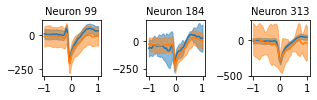

In [601]:
onoff=1
sampling_f=30000
maxwvch=cell_metrics['maxWaveformCh'][uid-1]
uid_share_ch = cell_metrics['UID'][cell_metrics['maxWaveformCh']==maxwvch]

n_spks_min=5

uid_to_choose=np.array(list(res['all'][onoff][sw_id]['pre'].keys()))
uid_sel = np.array([uu for uu in uid_share_ch if uu in uid_to_choose])
uid_sel=[99,184,313]
# uid_sel = np.random.choice(uid_to_choose,3)
# uid_sel=[4,11,14]
# uid_sel=[31,44,47,62,69,85,86,88,90,92,97]
nplots = len(uid_sel)
fig,axs=ph.subplots_wrapper(nplots,baseheight=1.5,basewidth=1.5)

# fig,axs=plt.subplots(1,nplots,figsize=(nplots*1.5,1.5))

for ii,uu in enumerate(uid_sel):
    ax=axs.ravel()[ii]
#     ax=axs[ii]
#     if (res['all'][onoff][sw_id]['pre'][uu].shape[0]>n_spks_min)&(res['all'][onoff][sw_id]['pre'][uu].shape[0]>n_spks_min):
    for pp,prepost in enumerate(['pre','post']):
        wf=res['all'][onoff][sw_id][prepost][uu]
        wf=pd.DataFrame(wf)
        times=np.linspace(-nbins/2/sampling_f,nbins/2/sampling_f,nbins) * 1000 # in ms
        wf.columns=times
        ph.mean_error_plot(wf,ax=ax,c=f'C{pp}')
    ax.set_title(f'Neuron {int(uu)}')
plt.tight_layout()
             

figfn = f'onoff{onoff}_waveform_ex_{sess}_{int(ti)}_{int(tt_plot)}_{int(uid)}_{int(field_index)}_indexwithin{int(index_within)}_swind{sw_id}'
ph.save_given_name(fig,figfn,figdir=figdir)

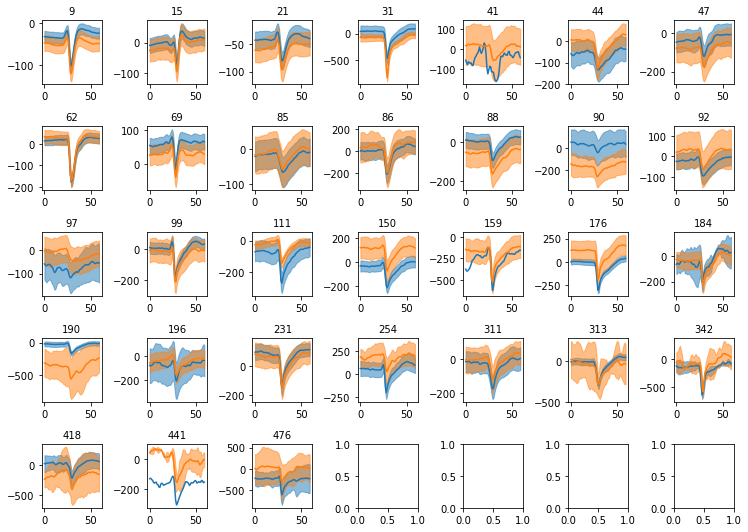

In [474]:
# onoff=1
# uid_to_choose=np.array(list(res['all'][onoff][sw_id]['pre'].keys()))
# # uid_sel = np.random.choice(uid_to_choose,3)
# # uid_sel=[4,11,14]
# # uid_sel=[31,44,47,62,69,85,86,88,90,92,97]
# nplots = len(uid_sel)
# nplots=len(uid_to_choose)
# fig,axs=ph.subplots_wrapper(nplots,baseheight=1.5,basewidth=1.5)

# # fig,axs=plt.subplots(1,nplots,figsize=(nplots*1.5,1.5))

# # for ii,uu in enumerate(uid_sel):
# for ii,uu in enumerate(uid_to_choose):
#     ax=axs.ravel()[ii]
# #     ax=axs[ii]
#     for pp,prepost in enumerate(res['all'][onoff][sw_id].keys()):
#         wf=res['all'][onoff][sw_id][prepost][uu]
#         wf=pd.DataFrame(wf)
#         ph.mean_error_plot(wf,ax=ax,c=f'C{pp}')
#     ax.set_title(uu)
# plt.tight_layout()

/tmp/ipykernel_1756189/2432979001.py:1: PerformanceWarning: indexing past lexsort depth may impact performance.
  rm=fr_map_trial_df_all.loc[(ani,sess,ti,tt_plot,190),:].T


(<Figure size 216x144 with 2 Axes>, <Axes: xlabel='Position'>)

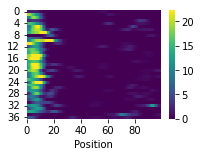

In [476]:
# rm=fr_map_trial_df_all.loc[(ani,sess,ti,tt_plot,190),:].T
# ph.ratemap_one_raw(rm)

##### off

In [629]:
# one example ratemap
sub=all_sw_onesess.query('switch==-1&post_mean_fr_all_norm<0.3&uid==150')
row=sub.iloc[2]
sw_id=row.name
tt,uid,field_index,index_within,trial_index=row['trialtype'],row['uid'],row['field_index'],row['index_within'],row['trial_index']

/tmp/ipykernel_1756189/315407457.py:5: PerformanceWarning: indexing past lexsort depth may impact performance.
  frmap_one=fr_map_trial_df_pyr_combined_all.loc[(ani,sess,0,tt_plot,uid),:].dropna(axis=1)
/mnt/home/szheng/projects/util_code/plot_helper.py:626: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(x_tick_labels, rotation=0)


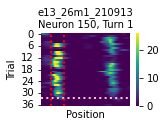

In [617]:
trial_index_to_index_within_df_one=trial_index_to_index_within_df_all[ani,sess].loc[ti]
row=trial_index_to_index_within_df_one.loc[trial_index_to_index_within_df_one.index.get_level_values(1)==trial_index]
tt_plot=row.index[0][0]

frmap_one=fr_map_trial_df_pyr_combined_all.loc[(ani,sess,0,tt_plot,uid),:].dropna(axis=1)

st,ed=all_fields_recombined_all.loc[(ani,sess,ti,tt,uid,field_index),['start','end']]

### ratemap example
fig,ax=plt.subplots(figsize=(2,4/3))
fig,ax=ph.ratemap_one_raw(frmap_one.T,trial=index_within,field_bound=(st,ed),fig=fig,ax=ax)
ax.set_xticks([])
ax.set_ylabel('Trial')
ax.set_title(f'{sess}\nNeuron {uid}, Turn {int(tt_plot)}')
figfn = f'ratemap_ex_{sess}_{int(ti)}_{int(tt_plot)}_{int(uid)}_{int(field_index)}_swind{int(sw_id)}'
ph.save_given_name(fig,figfn,figdir=figdir)

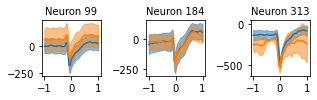

In [604]:
onoff=-1
sampling_f=30000
maxwvch=cell_metrics['maxWaveformCh'][uid-1]
uid_share_ch = cell_metrics['UID'][cell_metrics['maxWaveformCh']==maxwvch]

n_spks_min=5

uid_to_choose=np.array(list(res['all'][onoff][sw_id]['pre'].keys()))
uid_sel = np.array([uu for uu in uid_share_ch if uu in uid_to_choose])
uid_sel=[99,184,313]
# uid_sel = np.random.choice(uid_to_choose,3)
# uid_sel=[4,11,14]
# uid_sel=[31,44,47,62,69,85,86,88,90,92,97]
nplots = len(uid_sel)
fig,axs=ph.subplots_wrapper(nplots,baseheight=1.5,basewidth=1.5)

# fig,axs=plt.subplots(1,nplots,figsize=(nplots*1.5,1.5))

for ii,uu in enumerate(uid_sel):
    ax=axs.ravel()[ii]
#     ax=axs[ii]
#     if (res['all'][onoff][sw_id]['pre'][uu].shape[0]>n_spks_min)&(res['all'][onoff][sw_id]['pre'][uu].shape[0]>n_spks_min):
    for pp,prepost in enumerate(['pre','post']):
        wf=res['all'][onoff][sw_id][prepost][uu]
        wf=pd.DataFrame(wf)
        times=np.linspace(-nbins/2/sampling_f,nbins/2/sampling_f,nbins) * 1000 # in ms
        wf.columns=times
        ph.mean_error_plot(wf,ax=ax,c=f'C{pp}')
    ax.set_title(f'Neuron {int(uu)}')
plt.tight_layout()
             

figfn = f'onoff{onoff}_waveform_ex_{sess}_{int(ti)}_{int(tt_plot)}_{int(uid)}_{int(field_index)}_indexwithin{int(index_within)}_swind{sw_id}'
ph.save_given_name(fig,figfn,figdir=figdir)

/tmp/ipykernel_1756189/4263732701.py:2: PerformanceWarning: indexing past lexsort depth may impact performance.
  rm=fr_map_trial_df_all.loc[(ani,sess,ti,tt_plot,uu_),:].T


Text(0.5, 1.0, '41')

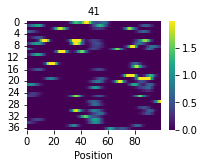

In [528]:
# uu_=41
# rm=fr_map_trial_df_all.loc[(ani,sess,ti,tt_plot,uu_),:].T
# fig,ax=ph.ratemap_one_raw(rm)
# ax.set_title(uu_)



### aggregate

In [605]:

post_minus_pre_all = spk_amp_prepost_all['post']-spk_amp_prepost_all['pre']
toplot=post_minus_pre_all.reset_index(level=0)

for onoff in [1,-1]:
    wilcoxon_res=scipy.stats.wilcoxon(post_minus_pre_all.loc[onoff])
    print(onoff_str_d[onoff])
    print(wilcoxon_res)


ON
WilcoxonResult(statistic=30039567.5, pvalue=0.7185653718261666)
OFF
WilcoxonResult(statistic=24669511.5, pvalue=0.352258166434786)


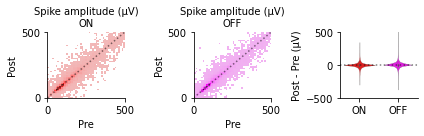

In [612]:
fig,axs=plt.subplots(1,3,figsize=(6,2))
ax.set_aspect('equal')
color_d = {1:'red',-1:'magenta'}
onoff_str_d={1:'ON',-1:'OFF'}
for ii,onoff in enumerate([1,-1]):
    ax=axs[ii]
    onoff_str = onoff_str_d[onoff]
#     sns.scatterplot(data=spk_amp_prepost_all.loc[onoff],x='pre',y='post',ax=ax,s=1,
#                    )
    sns.histplot(data=spk_amp_prepost_all.loc[onoff],x='pre',y='post',ax=ax,color=color_d[onoff]
                   )
    ax.set_xlim([-1,500])
    ax.set_xticks([0,500])
    ax.set_ylim([-1,500])
    ax.set_yticks([0,500])
    ax.set_xlabel('Pre')
    ax.set_ylabel('Post')
    ax.set_title(u'Spike amplitude (\u03bcV)'+f'\n{onoff_str}')
    ax.plot([0,1],[0,1],transform=ax.transAxes,c='k',linestyle=':',alpha=0.5)

ax=axs[2]
sns.violinplot(data=toplot,x='level_0',y=toplot[0],ax=ax,palette=color_d,order=[1,-1],linewidth=0.2)
ax.set_xticklabels(['ON','OFF'])
ax.axhline(0,c='k',linestyle=':',alpha=0.5)
ax.set_xlabel('')
ax.set_ylabel(u'Post - Pre (\u03bcV)')
ax.set_title('')
ax.set_ylim([-500,500])
sns.despine()
plt.tight_layout()


figfn = f'{sess}_prepost_spk_waveform_amp_peri_switch'
ph.save_given_name(fig,figfn,figdir=figdir)

<Axes: >

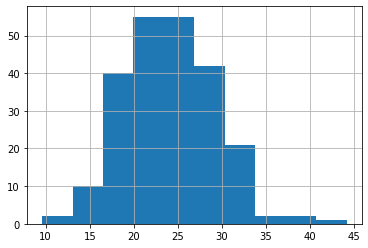

In [456]:
post_minus_pre_all.groupby(level=(0,1)).apply(lambda x:x.abs().mean()).loc[1].hist()

<Axes: xlabel='level_0', ylabel='post'>

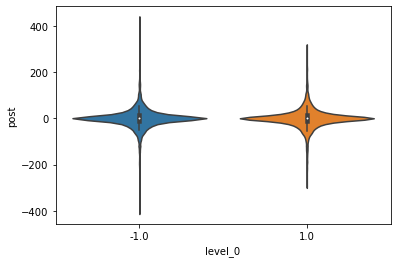

In [332]:


# sns.stripplot(data=toplot,x='level_0',y='post')

In [253]:
res['all'][onoff][sw_id]['pre'][uu]

array([[-1.12514999e+02, -1.06859993e+02, -1.15439995e+02,
        -1.26749992e+02, -1.23824997e+02, -1.21679993e+02,
        -1.24799995e+02, -1.24994995e+02, -1.31039993e+02,
        -1.28114990e+02, -1.26944992e+02, -1.35330002e+02,
        -1.36110001e+02, -1.40205002e+02, -1.46250000e+02,
        -1.58339996e+02, -1.75694992e+02, -1.78034988e+02,
        -1.85834991e+02, -2.04944992e+02, -2.09624985e+02,
        -2.16059998e+02, -2.14499985e+02, -2.16644989e+02,
        -2.04359985e+02, -1.83299988e+02, -1.72184998e+02,
        -2.89964996e+02, -5.16750000e+02, -6.53054993e+02,
        -5.81880005e+02, -4.19639984e+02, -3.33254974e+02,
        -3.01664978e+02, -2.82164978e+02, -2.59349976e+02,
        -2.36339996e+02, -2.21324997e+02, -2.05334991e+02,
        -1.94609985e+02, -1.88369995e+02, -1.96754990e+02,
        -2.13134995e+02, -2.08259995e+02, -1.88174988e+02,
        -1.75304993e+02, -1.75110001e+02, -1.69259995e+02,
        -1.56779999e+02, -1.56779999e+02, -1.37864990e+0

(0.0, 500.0)

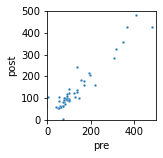

In [153]:
# corresponding pre post spk amplitude peri that switch
fig,ax=plt.subplots(figsize=(2,2))
ax.set_aspect('equal')
sns.scatterplot(data=spk_amp_prepost_all.loc[1,sw_id],x='pre',y='post',s=6,ax=ax)
ax.set_xlim([0,500])
ax.set_ylim([0,500])


In [157]:
# spk_amp_prepost_all.loc[1,sw_id].diff(axis=1).idxmin()
spk_amp_prepost_all.loc[1,sw_id].diff(axis=1).idxmax()



pre       NaN
post    461.0
dtype: float64

/tmp/ipykernel_1756189/1482208744.py:1: PerformanceWarning: indexing past lexsort depth may impact performance.
  frmap_one=fr_map_trial_df_pyr_combined_all.loc[(ani,sess,0,tt,461),:].dropna(axis=1)
/mnt/home/szheng/projects/util_code/plot_helper.py:626: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(x_tick_labels, rotation=0)


(<Figure size 216x144 with 2 Axes>, <Axes: xlabel='Position'>)

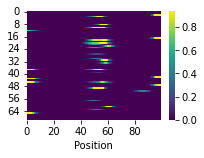

In [158]:
frmap_one=fr_map_trial_df_pyr_combined_all.loc[(ani,sess,0,tt,461),:].dropna(axis=1)
ph.ratemap_one_raw(frmap_one.T)

In [62]:
pd.concat(spk_amp_prepost_all[1][1]).unstack(level=0).dropna(axis=0)

,pre,post
4,134.480255,135.231598
11,62.435329,64.348778
14,82.804260,79.763924
18,94.899292,93.489525
29,102.745323,101.558693
...,...,...
460,224.152481,168.187500
461,167.387985,176.397003
468,54.892502,4.039291
477,-30.809998,5.070000


In [55]:
pd.Series(spk_amp_prepost_all[1][1]['pre'])

4      134.480255
11      62.435329
14      82.804260
18      94.899292
29     102.745323
          ...    
460    224.152481
461    167.387985
468     54.892502
477    -30.809998
481     50.877560
Length: 61, dtype: float32

In [51]:
pd.DataFrame(spk_amp_prepost_all[1])

,1,4,9,11,13,14,19,25,26,28,...,414,418,419,420,422,423,425,426,429,430
pre,"{4: 134.48026, 11: 62.43533, 14: 82.80426, 18:...","{4: 135.13632, 11: 62.942307, 14: 82.73715, 18...","{4: 136.53966, 11: 60.578434, 14: 79.5608, 18:...","{4: 135.03816, 11: 62.496197, 14: 82.667885, 1...","{4: 134.45107, 11: 61.918644, 14: 82.80976, 18...","{4: 136.21878, 11: 60.82374, 14: 79.11985, 18:...","{4: 135.32916, 11: 63.909874, 14: 81.92648, 18...","{4: 132.98067, 11: 62.34519, 14: 78.922905, 18...","{4: 134.48361, 11: 62.811752, 14: 78.89628, 18...","{4: 133.22763, 11: 63.728092, 14: 79.41271, 18...",...,"{4: 138.40097, 11: 62.80497, 14: 75.40337, 18:...","{4: 134.1865, 11: 61.01605, 14: 73.97421, 18: ...","{4: 134.97403, 11: 61.275963, 14: 73.7442, 18:...","{4: 136.3882, 11: 62.171722, 14: 73.763504, 18...","{4: 134.02075, 11: 61.149696, 14: 73.29395, 18...","{4: 136.62338, 11: 62.223618, 14: 73.75201, 18...","{4: 134.97403, 11: 61.275963, 14: 73.7442, 18:...","{4: 133.92856, 11: 60.915115, 14: 73.31838, 18...","{4: 134.02394, 11: 60.898453, 14: 73.577225, 1...","{4: 134.97403, 11: 61.275963, 14: 73.7442, 18:..."
post,"{4: 135.2316, 11: 64.34878, 14: 79.76392, 18: ...","{4: 134.47232, 11: 64.009995, 14: 79.780396, 1...","{4: 136.40245, 11: 63.91323, 14: 83.40649, 18:...","{4: 134.91977, 11: 64.23032, 14: 79.60815, 18:...","{4: 135.32465, 11: 64.7102, 14: 79.97003, 18: ...","{4: 136.69086, 11: 64.22605, 14: 83.34505, 18:...","{4: 132.82433, 11: 62.677124, 14: 79.029755, 1...","{4: 136.51811, 11: 62.644848, 14: 79.5214, 18:...","{4: 136.32866, 11: 62.494453, 14: 79.37431, 18...","{4: 138.28688, 11: 63.464123, 14: 80.1772, 18:...",...,"{4: 139.98389, 11: 61.099884, 14: 74.8678, 18:...","{4: 134.90517, 11: 59.13801, 14: 73.02159, 18:...","{4: 134.19833, 11: 59.50856, 14: 73.02804, 18:...","{4: 134.86404, 11: 59.28357, 14: 74.37503, 18:...","{4: 134.26215, 11: 59.024567, 14: 72.99508, 18...","{4: 134.6368, 11: 59.34513, 14: 74.2943, 18: 9...","{4: 134.19833, 11: 59.50856, 14: 73.02804, 18:...","{4: 134.57529, 11: 59.328766, 14: 73.22221, 18...","{4: 134.77222, 11: 59.1627, 14: 73.09866, 18: ...","{4: 134.19833, 11: 59.50856, 14: 73.02804, 18:..."


In [ ]:
get_spk_amplitude()

29

In [37]:
peaks,_=scipy.signal.find_peaks(onespk)
trough=peaks[peaks<midpoint][-1]
amp = onespk[trough] - onespk[midpoint]

In [38]:
amp

64.34878

In [32]:
res['avg'][1][1]['post'].keys()

dict_keys([4, 11, 14, 18, 29, 34, 36, 38, 42, 50, 55, 61, 82, 83, 87, 116, 122, 125, 129, 131, 136, 156, 158, 164, 170, 173, 185, 207, 210, 212, 219, 222, 225, 227, 235, 236, 238, 239, 260, 264, 266, 273, 282, 305, 322, 324, 346, 360, 361, 368, 372, 375, 379, 389, 393, 459, 460, 461, 468, 477, 481])

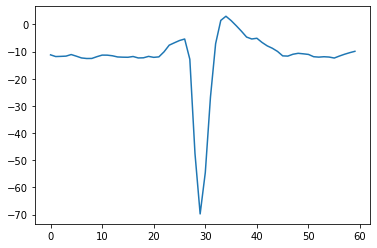

In [33]:
onespk=res['avg'][1][1]['post'][11]
plt.plot(onespk)

In [147]:
sw_row=all_sw_onesess.iloc[0]

In [149]:
uid,sw_time=sw_row['uid'],sw_row['time']

In [153]:
shank_id = cell_metrics['shankID'][uid-1]

In [154]:
uid_with_same_uid = cell_metrics['UID'][cell_metrics['shankID']==shank_id]

In [ ]:
spi

In [155]:
uid_with_same_uid

array([  4.,  11.,  14.,  18.,  29.,  34.,  36.,  38.,  42.,  50.,  55.,
        61.,  82.,  83.,  87., 116., 122., 125., 129., 131., 136., 156.,
       158., 164., 170., 173., 185., 207., 210., 212., 219., 222., 225.,
       227., 235., 236., 238., 239., 260., 264., 266., 273., 277., 282.,
       289., 302., 303., 305., 322., 324., 346., 358., 360., 361., 363.,
       368., 372., 375., 379., 389., 393., 421., 433., 459., 460., 461.,
       468., 477., 481.])

## scratch paper for extracting waveforms; 
for the correct version, see code/extract_waveform_script.py

In [427]:
import pynapple as nap
win_sz_half = 20
# peri_switch_epoch = nap.IntervalSet(start=sw_time-win_sz_half,end=sw_time-0.01)
peri_switch_epoch = nap.IntervalSet(start=sw_time+0.01,end=sw_time+win_sz_half)
pre_post_epoch = {
    'pre':nap.IntervalSet(start=sw_time-win_sz_half,end=sw_time-0.01),
    'post':nap.IntervalSet(start=sw_time+0.01,end=sw_time+win_sz_half)

}

In [279]:
uid=150
shank_id = cell_metrics['shankID'][uid-1]
uid_with_same_shank = cell_metrics['UID'][cell_metrics['shankID']==shank_id]

In [280]:
uid_with_same_shank

array([  9.,  15.,  21.,  31.,  41.,  44.,  47.,  62.,  69.,  85.,  86.,
        88.,  90.,  92.,  97.,  99., 111., 150., 159., 172., 176., 184.,
       190., 192., 196., 231., 253., 254., 278., 296., 311., 313., 326.,
       337., 342., 397., 404., 406., 417., 418., 426., 431., 432., 441.,
       476.])

In [287]:
res['avg'][1].keys()

dict_keys([1, 4, 9, 11, 13, 14, 19, 25, 26, 28, 32, 34, 35, 36, 38, 40, 41, 44, 45, 46, 48, 49, 50, 52, 53, 55, 57, 59, 60, 64, 66, 70, 71, 77, 83, 84, 85, 86, 87, 88, 89, 93, 94, 96, 102, 105, 109, 110, 111, 112, 113, 114, 115, 119, 122, 124, 125, 126, 128, 130, 131, 133, 139, 140, 141, 144, 147, 149, 156, 160, 162, 165, 166, 167, 169, 172, 174, 175, 177, 178, 181, 184, 186, 187, 188, 189, 190, 191, 196, 197, 198, 199, 200, 201, 202, 204, 207, 209, 210, 212, 213, 216, 218, 221, 222, 223, 224, 225, 226, 227, 229, 231, 232, 233, 236, 237, 240, 241, 242, 244, 246, 249, 250, 252, 254, 255, 256, 257, 258, 259, 260, 261, 265, 269, 272, 273, 275, 276, 278, 279, 280, 282, 283, 284, 285, 286, 287, 288, 291, 292, 293, 296, 298, 299, 302, 303, 304, 309, 310, 311, 312, 314, 315, 316, 317, 318, 319, 320, 324, 325, 331, 332, 335, 336, 337, 338, 340, 341, 342, 347, 348, 349, 351, 352, 353, 354, 355, 356, 358, 359, 361, 364, 365, 367, 368, 369, 370, 371, 372, 375, 376, 377, 379, 381, 382, 383, 384, 3

In [289]:
sw_id

84

In [290]:
res['avg'][1][sw_id]['pre'].keys()

dict_keys([4, 11, 14, 18, 29, 34, 36, 38, 42, 50, 61, 82, 83, 87, 116, 122, 125, 129, 131, 136, 164, 173, 207, 210, 219, 222, 227, 235, 238, 239, 260, 266, 282, 303, 305, 322, 324, 346, 368, 379, 393, 421, 433, 459, 461, 468, 481])

In [454]:
def get_waveform_pre_post(uid,sw_time, 
                          cell_metrics,
                          win_sz_half=20,
                          spk_win_sz_half=0.001
                         ):
    '''
    win_sz_half: window peri switch
    spk_win_sz_half: window peri spike
    
    waveform_allspk_alluid_ep: {'pre':{uid:(n_spks x n_bin_in_spk_win)}, 'post':}
    waveform_avgspk_alluid_ep: {'pre':{uid: (n_bin_in_spk_win, )}, 'post':}
    '''
    
    # get cells with the same shank
    shank_id = cell_metrics['shankID'][uid-1]
    uid_with_same_shank = cell_metrics['UID'][cell_metrics['shankID']==shank_id]
    # get window of spike around the switch
    
    peri_switch_epoch = nap.IntervalSet(start=sw_time+0.01,end=sw_time+win_sz_half)
    pre_post_epoch = {
        'pre':nap.IntervalSet(start=sw_time-win_sz_half,end=sw_time-0.01),
        'post':nap.IntervalSet(start=sw_time+0.01,end=sw_time+win_sz_half)
    }
    
    # get waveform for spikes in the windows
    waveform_allspk_alluid_ep = {}
    waveform_avgspk_alluid_ep={}
    for prepost,ep in pre_post_epoch.items():
        peri_switch_epoch =pre_post_epoch[prepost]
        spike_trains_restrict=spike_trains.restrict(peri_switch_epoch)[uid_with_same_shank]
        waveform_allspk_alluid={}
        waveform_avgspk_alluid = {}
        for k,val in spike_trains_restrict.items():
            ch=int(cell_metrics['maxWaveformCh'][k-1])
            waveform_allspk_oneuid=[]

            for t in val.index:
                loaded_data=anasigproxy.load(time_slice=(t-0.001,t+0.001))
                loaded_data = loaded_data*to_microV_factor
                waveform_one=loaded_data[:,ch]
                waveform_allspk_oneuid.append(waveform_one)
            if len(waveform_allspk_oneuid)>0:
                waveform_allspk_oneuid=np.array(waveform_allspk_oneuid)[:,:,0]
                waveform_allspk_alluid[k] = waveform_allspk_oneuid
                waveform_avgspk_alluid[k]= waveform_allspk_oneuid.mean(axis=0)
        waveform_allspk_alluid_ep[prepost] = waveform_allspk_alluid
        waveform_avgspk_alluid_ep[prepost] = waveform_avgspk_alluid
    common_uid=np.array([k for k in waveform_allspk_alluid_ep['pre'].keys() if k in waveform_allspk_alluid_ep['post'].keys()])
    for prepost in waveform_allspk_alluid_ep.keys():
        waveform_allspk_alluid_ep[prepost] = {k:waveform_allspk_alluid_ep[prepost][k] for k in common_uid}
        waveform_avgspk_alluid_ep[prepost] = {k:waveform_avgspk_alluid_ep[prepost][k] for k in common_uid}
    
    return waveform_allspk_alluid_ep, waveform_avgspk_alluid_ep


In [456]:
%%time
import tqdm
gpb=all_sw_onesess.groupby('switch')
waveform_allspk_alluid_ep_allsw={}
waveform_avgspk_alluid_ep_allsw={}
for onoff,all_sw_onesess_onoff in gpb:
    waveform_allspk_alluid_ep_allsw[onoff] = {}
    waveform_avgspk_alluid_ep_allsw[onoff]={}
    for sw_id,sw_row in tqdm.tqdm(all_sw_onesess_onoff.iterrows(),total=all_sw_onesess_onoff.shape[0]):
        uid,sw_time=sw_row['uid'],sw_row['time']
        waveform_allspk_alluid_ep, waveform_avgspk_alluid_ep = get_waveform_pre_post(uid,sw_time, 
                          cell_metrics,
                          win_sz_half=20,
                          spk_win_sz_half=0.001
                         )
        waveform_allspk_alluid_ep_allsw[onoff][sw_id] = waveform_allspk_alluid_ep
        waveform_avgspk_alluid_ep_allsw[onoff][sw_id] = waveform_avgspk_alluid_ep
        

100%|██████████| 230/230 [40:51<00:00, 10.66s/it]

CPU times: user 1h 17min 31s, sys: 11.1 s, total: 1h 17min 42s
Wall time: 1h 17min 53s


In [457]:
res = {'all':waveform_allspk_alluid_ep_allsw,'avg':waveform_avgspk_alluid_ep_allsw}
save_fn_full = os.path.join(data_dir_full,'py_data','waveform_peri_sw.p')
import pickle
pickle.dump(res,open(save_fn_full,'wb'))

In [449]:
waveform_allspk_alluid_ep

{'pre': {4: array([[-439.335   , -428.61    , -437.775   , ..., -492.76498 ,
          -485.745   , -472.09497 ],
         [-505.245   , -506.41498 , -517.92    , ..., -476.18997 ,
          -466.43997 , -478.91998 ],
         [-487.49997 , -493.93497 , -494.12997 , ..., -462.735   ,
          -451.81497 , -429.78    ],
         ...,
         [  93.99    ,  100.619995,   85.02    , ...,  119.145   ,
           122.46    ,  127.725   ],
         [ 213.71999 ,  213.915   ,  195.39    , ...,  274.16998 ,
           264.03    ,  246.87    ],
         [ 270.85498 ,  261.69    ,  251.93999 , ...,  341.63998 ,
           343.97998 ,  304.785   ]], dtype=float32),
  11: array([[-475.215   , -486.91498 , -500.955   , ..., -479.69998 ,
          -496.46997 , -480.675   ],
         [-402.28497 , -409.11    , -414.96    , ..., -344.175   ,
          -357.24    , -358.215   ],
         [ 272.61    ,  249.98999 ,  245.89499 , ...,  288.79498 ,
           280.41    ,  287.235   ],
         ...,
     

In [428]:
%%time
waveform_allspk_alluid_ep = {}
waveform_avgspk_alluid_ep={}
for prepost,ep in pre_post_epoch.items():
    peri_switch_epoch =pre_post_epoch[prepost]
    spike_trains_restrict=spike_trains.restrict(peri_switch_epoch)[uid_with_same_uid]
    waveform_allspk_alluid={}
    waveform_avgspk_alluid = {}
    for k,val in spike_trains_restrict.items():
        ch=int(cell_metrics['maxWaveformCh'][k-1])
        waveform_allspk_oneuid=[]

        for t in val.index:
            loaded_data=anasigproxy.load(time_slice=(t-0.001,t+0.001))
            loaded_data = loaded_data*to_microV_factor
            waveform_one=loaded_data[:,ch]
            waveform_allspk_oneuid.append(waveform_one)
        if len(waveform_allspk_oneuid)>0:
            waveform_allspk_oneuid=np.array(waveform_allspk_oneuid)[:,:,0]
            waveform_allspk_alluid[k] = waveform_allspk_oneuid
            waveform_avgspk_alluid[k]= waveform_allspk_oneuid.mean(axis=0)
    waveform_allspk_alluid_ep[prepost] = waveform_allspk_alluid
    waveform_avgspk_alluid_ep[prepost] = waveform_avgspk_alluid
common_uid=np.array([k for k in waveform_allspk_alluid_ep['pre'].keys() if k in waveform_allspk_alluid_ep['post'].keys()])
for prepost in waveform_allspk_alluid_ep.keys():
    waveform_allspk_alluid_ep[prepost] = {k:waveform_allspk_alluid_ep[prepost][k] for k in common_uid}
    waveform_avgspk_alluid_ep[prepost] = {k:waveform_avgspk_alluid_ep[prepost][k] for k in common_uid}
    

CPU times: user 11.3 s, sys: 38 ms, total: 11.4 s
Wall time: 11.7 s


In [396]:
spk_amp_prepost={prepost:{k:waveform_allspk_alluid_ep[prepost][k].min(axis=1) for k in common_uid} for prepost in waveform_allspk_alluid_ep.keys()}

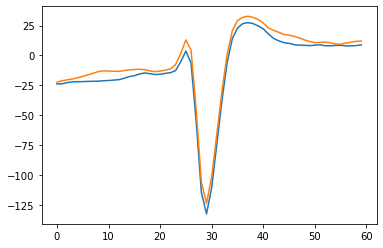

In [448]:
plt.plot(waveform_avgspk_alluid_ep['pre'][4])
plt.plot(waveform_avgspk_alluid_ep['post'][4])

In [425]:
uid=common_uid[14]

(array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0.]),
 array([225.11499023, 225.21499634, 225.31498718, 225.41499329,
        225.51498413, 225.61499023, 225.71499634, 225.81498718,
        225.91499329, 226.01498413, 226.11499023]),
 <BarContainer object of 10 artists>)

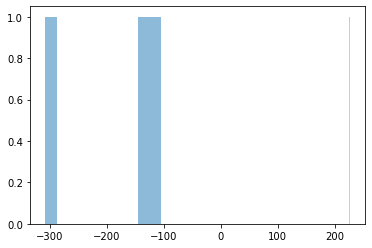

In [426]:

plt.hist(spk_amp_prepost['pre'][uid],alpha=0.5)
plt.hist(spk_amp_prepost['post'][uid],alpha=0.5)

In [353]:
[waveform_allspk_alluid_ep[prepost][k].shape for k in common_uid]

[(231, 60),
 (189, 60),
 (208, 60),
 (81, 60),
 (39, 60),
 (15, 60),
 (27, 60),
 (2, 60),
 (6, 60),
 (17, 60),
 (9, 60),
 (5, 60),
 (7, 60),
 (7, 60),
 (29, 60),
 (60,),
 (18, 60),
 (60,),
 (3, 60),
 (0,),
 (60,),
 (0,),
 (0,),
 (27, 60),
 (60,),
 (60,),
 (2, 60),
 (2, 60),
 (60,),
 (0,),
 (2, 60),
 (3, 60),
 (0,),
 (60,),
 (12, 60),
 (7, 60),
 (29, 60),
 (4, 60),
 (7, 60),
 (0,),
 (28, 60),
 (8, 60),
 (0,),
 (3, 60),
 (0,),
 (0,),
 (0,),
 (60,),
 (0,),
 (5, 60),
 (60,),
 (0,),
 (2, 60),
 (0,),
 (0,),
 (60,),
 (0,),
 (0,),
 (39, 60),
 (5, 60),
 (6, 60),
 (0,),
 (0,),
 (60,),
 (2, 60),
 (0,),
 (0,),
 (0,),
 (56, 60)]

In [349]:
common_uid=np.array([k for k in waveform_allspk_alluid_ep['pre'].keys() if k in waveform_allspk_alluid_ep['post'].keys()])



In [343]:
len(waveform_allspk_alluid_ep['pre'])

69

In [344]:
len(waveform_allspk_alluid_ep['post'])

69

In [337]:
waveform_one

AnalogSignal with 1 channels of length 300; units dimensionless; datatype float32
name: 'Signals'
annotations: {'stream_id': '0'}
sampling rate: 30000.0 Hz
time: 7969.072266666667 s to 7969.082266666667 s

In [298]:
t=spike_trains_restrict[210].index[0]
ch=int(cell_metrics['maxWaveformCh'][210-1])
loaded_data=anasigproxy.load(time_slice=(t-0.005,t+0.005))
loaded_data = loaded_data*to_microV_factor

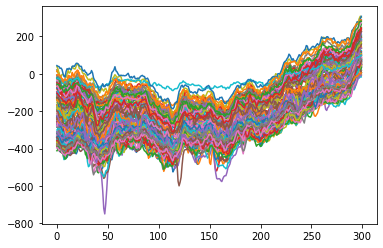

In [318]:
plt.plot(loaded_data)

In [246]:
waveform_allspk_alluid.keys()

dict_keys([4, 11, 14, 18, 29, 34, 36, 38, 42, 50, 55, 61, 82, 83, 87, 116, 122, 125, 129, 131, 136, 156, 158, 164, 170, 173, 185, 207, 210, 212, 219, 222, 225, 227, 235, 236, 238, 239, 260, 264, 266, 273, 277, 282, 289, 302, 303, 305, 322, 324, 346, 358, 360, 361, 363, 368, 372, 375, 379, 389, 393, 421, 433, 459, 460, 461, 468, 477, 481])

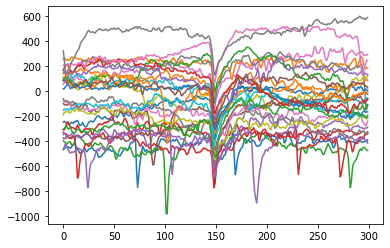

In [336]:
plt.plot(waveform_allspk_alluid[266].T)

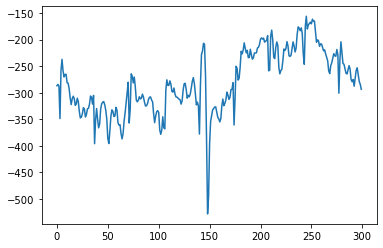

In [330]:
plt.plot(waveform_allspk_alluid[266].T)

In [190]:
loaded_data

AnalogSignal with 128 channels of length 0; units dimensionless; datatype float32
name: 'Signals'
annotations: {'stream_id': '0'}
sampling rate: 30000.0 Hz
time: 7964.356133333334 s to 7964.356133333334 s

In [187]:
val.index

Float64Index([      7964.085, 7964.153133333,      7964.1738, 7964.205866667,
              7964.292433333,      7964.3187, 7964.361133333],
             dtype='float64', name='Time (s)')

In [159]:

peri_switch_epoch

,start,end
0,7963.387367,7965.387367


In [157]:
spike_trains

  Index    rate  celltype              ispyr    isint
-------  ------  ------------------  -------  -------
      1    0.04  Pyramidal Cell            1        0
      2    0.04  Pyramidal Cell            1        0
      3    0.04  Pyramidal Cell            1        0
      4   27.03  Narrow Interneuron        0        1
      5   25.93  Narrow Interneuron        0        1
      6   21.7   Narrow Interneuron        0        1
      7   16.62  Narrow Interneuron        0        1
      8   26.24  Narrow Interneuron        0        1
      9   20.79  Narrow Interneuron        0        1
     10   17.18  Narrow Interneuron        0        1
     11   19.62  Narrow Interneuron        0        1
     12   17.62  Narrow Interneuron        0        1
     13   13.12  Narrow Interneuron        0        1
     14   22.72  Narrow Interneuron        0        1
     15   11.1   Narrow Interneuron        0        1
     16   11.3   Narrow Interneuron        0        1
     17   17.36  Narrow Inte

In [267]:
ch=int(cell_metrics['maxWaveformCh'][136-1])

In [268]:
ch

76

In [275]:
one_spk_time=cell_metrics.spikes.times[136-1][1]

In [545]:
dat_fn = os.path.join(data_dir_full,f'{sess_name}.dat')

In [546]:
from quantities import mV

In [551]:
import neo
import neo.rawio

reader = neo.io.RawBinarySignalIO(dat_fn,dtype='int16',
                                  nb_channel=128,
                                  sampling_rate=30000,
                                 )

# reader = neo.rawio.IntanRawIO(filename=dat_fn)
reader.parse_header()
# block = reader.read_block()
# signal = block.segments[0].analogsignals[0]

to_microV_factor=0.195

In [552]:
data_lazy=reader.read(lazy=True)

In [553]:
anasigproxy=data_lazy[0].segments[0].analogsignals[0]

In [554]:
anasigproxy.sampling_rate

array(30000.) * Hz

In [555]:
# one_spk_time=cell_metrics.spikes.times[136-1][4]
one_spk_time=cell_metrics.spikes.times[0][0]
ch = int(cell_metrics['maxWaveformCh'][0])
loaded_data=anasigproxy.load(time_slice=(one_spk_time-0.01,one_spk_time+0.010))
loaded_data = loaded_data*to_microV_factor

In [443]:
to_microV_factor=0.195

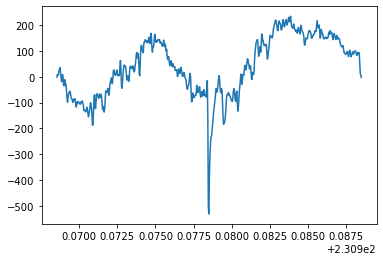

In [444]:

plt.plot(loaded_data.times,loaded_data[:,ch])

In [ ]:
import numpy as np
import neo

def extract_waveform(filename, channel_index, start_time, end_time, sampling_rate):
    """
    Extract waveform from a specific channel and time interval.

    Parameters:
    - filename: path to the .dat file
    - channel_index: index of the channel (0-indexed)
    - start_time: start time in seconds
    - end_time: end time in seconds
    - sampling_rate: sampling rate of the recording (in Hz)

    Returns:
    - waveform: extracted waveform as a numpy array
    """
    # Load the data
    reader = neo.io.RawBinarySignalIO(filename)
    block = reader.read_block()
    signal = block.segments[0].analogsignals[0]

    # Calculate start and end indices
    start_index = int(start_time * sampling_rate)
    end_index = int(end_time * sampling_rate)

    # Extract data for the specific channel and time interval
    waveform = signal[start_index:end_index, channel_index]

    return waveform.magnitude.flatten()  # Flatten and return the waveform data

# Example usage
filename = 'path_to_your_dat_file.dat'
channel_index = 0  # for example, channel 1
start_time = 0  # in seconds
end_time = 1  # in seconds
sampling_rate = 30000  # example sampling rate

waveform = extract_waveform(filename, channel_index, start_time, end_time, sampling_rate)
print(waveform)
